# **Model Building**

## **Part 2: Building a sentiment classification engine.**

### **Text Pre-processing and Model Building and Evaluation**

In [8]:
# Importing libraries
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import FreqDist
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

# model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve

### **Importing and Pre-processing Data**

In [9]:
# importing drive to upload dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
df_merged = pd.read_excel('/content/gdrive/My Drive/Web and Social Media Analytics - NLP Capstone Project/merged_excelfile.xlsx')

##### **Note: As we already created above file in part 1 and saved in gdrive for model building**

In [11]:
df_merged.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,review_sentiment,...,title,also_buy,brand,feature,details,price,category_new,new_rank,also_view_new,also_view_brand
0,1,0,A5JLAU2ARJ0BO,B0000E3GWH,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,1095724800,2,NEGATIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
1,4,0,A1ACM1CBGORBN1,B0000E3GWH,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,1090627200,15,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
2,3,0,A2V48Q03FZUOSD,B0000E3GWH,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,1089072000,11,NEGATIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
3,5,1,A1V3TRGWOMA8LC,B0000E3GWH,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,1081728000,4,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
4,3,0,A3NOBH42C7UI5M,B0000E3GWH,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,1077148800,12,POSITIVE,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]


In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63838 entries, 0 to 63837
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   overall           63838 non-null  int64  
 1   verified          63838 non-null  int64  
 2   reviewerID        63838 non-null  object 
 3   asin              63838 non-null  object 
 4   reviewerName      63827 non-null  object 
 5   reviewText        63837 non-null  object 
 6   summary           63820 non-null  object 
 7   unixReviewTime    63838 non-null  int64  
 8   vote              63838 non-null  object 
 9   review_sentiment  63838 non-null  object 
 10  Date&Time         63838 non-null  object 
 11  description       63838 non-null  object 
 12  title             63838 non-null  object 
 13  also_buy          63838 non-null  object 
 14  brand             63772 non-null  object 
 15  feature           63838 non-null  object 
 16  details           63838 non-null  object

In [13]:
# counting positive and negative instances
pos_neg = df_merged.review_sentiment.value_counts()
pos_neg

POSITIVE    47677
NEGATIVE    16161
Name: review_sentiment, dtype: int64

In [14]:
print("positive rate is about {0}%".format(round((pos_neg[0]/float(pos_neg[0]+pos_neg[1]))*100), 2))

positive rate is about 75%


In [15]:
print("negative rate is about {0}%".format(round((pos_neg[1]/float(pos_neg[0]+pos_neg[1]))*100), 2))

negative rate is about 25%


In [16]:
# mapping labels to 0 and 1
df_merged['review_sentiment'] = df_merged.review_sentiment.map({'POSITIVE':1, 'NEGATIVE':0})

In [17]:
df_merged.head()

,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,review_sentiment,...,title,also_buy,brand,feature,details,price,category_new,new_rank,also_view_new,also_view_brand
0,1,0,A5JLAU2ARJ0BO,B0000E3GWH,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,1095724800,2,0,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
1,4,0,A1ACM1CBGORBN1,B0000E3GWH,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,1090627200,15,1,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
2,3,0,A2V48Q03FZUOSD,B0000E3GWH,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,1089072000,11,0,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
3,5,1,A1V3TRGWOMA8LC,B0000E3GWH,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,1081728000,4,1,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]
4,3,0,A3NOBH42C7UI5M,B0000E3GWH,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,1077148800,12,1,...,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,[],Samsung,[],{},117.247465,Cell Phones,3059436.0,[''],[]


In [18]:
df_reviews = df_merged[["reviewText","review_sentiment"]]

In [19]:
df_reviews.head()

,reviewText,review_sentiment
0,This phone is ugly and heavy and has a terribl...,0
1,I had the Samsung V205 and then I decided to t...,1
2,This is the first Samsung phone I have had and...,0
3,"..and I'm from Europe, where the phones and ne...",1
4,This phone is amazingly small and light for a ...,1


### Pre-processing the text

In [20]:
# Reading stop words from a text file in to a list
stop_words = [line.rstrip('\n') for line in open('/content/gdrive/MyDrive/Web and social media analytics/stop_words_long.txt')]

In [21]:
# remove contraction and make it as normal string 
contractionsMain = {"ain't": "is not", "aren't": "are not","can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def getcontractions(contractionsMain):
    contraction_key = re.compile('(%s)' % '|'.join(contractionsMain.keys()))
    return contractionsMain, contraction_key

contractions, contraction_key = getcontractions(contractionsMain)
def replacecontractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contraction_key.sub(replace, text)

In [22]:
def remove_punctuations(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    
    return text

In [23]:
#function to remove numbers and punctuation marks
puncts_list=['!','@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']',':',';','?','/','\\','|','.','<','>']
def removepuctuationmarks(x):
    x = str(x)
    for punct in puncts_list:
        if punct in x:
            x = x.replace(punct, '')
    return x

In [24]:
# replace charachter appearing for more than twice in any word to single character 
def replace_multiple_characters(text):
        #repeat_pattern = re.compile(r'(\w)\1*')
        repeat_pattern = re.compile(r'(\w)\1{2,}')
        match_substitution = r'\1\1' 
        new_word = repeat_pattern.sub(match_substitution,text) 
        repeat_pattern1 = re.compile(r'(\w)\1{1,}$')
        match_substitution1 = r'\1' 
        new_word = repeat_pattern1.sub(match_substitution1,new_word) 
        return new_word

In [25]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
def preprocessText(document):
     # tokenize into words
         # change sentence to lower case
    document = document.lower()
    words = word_tokenize(document)
    # remove contractions
    words = [ replacecontractions(word) for word in words ]
    
    # remove stop words
    words = [word for word in words if word not in stop_words]
    
    # remove punctuation marks
    
    words=[remove_punctuations(word) for word in words]
    
    words=[replace_multiple_characters(word) for word in words]
    
    # remove stop words
    words = [word for word in words if word not in stop_words]
    
    #apply lemmatization
    words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

    words=[word for word in words if len(word)>2]
    # join words to make sentence
    document = " ".join(words)
    
    return document

In [26]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
df_reviews["reviewText"]=[preprocessText(str(x)) for x in df_reviews["reviewText"]]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
# convert to X and y
X = df_reviews.reviewText
y = df_reviews.review_sentiment
print(X.shape)
print(y.shape)

(63838,)
(63838,)


In [28]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [29]:
X_train.head()

42130    buy phone mom ago work great like complaints g...
53310                                                 good
23250    happy phone expect meet delivery time responsi...
32825    purchase phone upgrade aka optimus true lte ab...
32157                              gift granddaughter love
Name: reviewText, dtype: object

In [30]:
y_train.head()

42130    1
53310    1
23250    1
32825    1
32157    0
Name: review_sentiment, dtype: int64

In [31]:
# vectorizing the sentences
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [32]:
vect.fit(X_train)

CountVectorizer()

In [33]:
# printing the vocabulary
vect.vocabulary_

{'buy': 3247,
 'phone': 20274,
 'mom': 15288,
 'ago': 562,
 'work': 29871,
 'great': 10354,
 'like': 13722,
 'complaints': 4547,
 'get': 9875,
 'sale': 23483,
 'happy': 10708,
 'shes': 24205,
 'good': 10136,
 'expect': 8266,
 'meet': 14672,
 'delivery': 5982,
 'time': 27110,
 'responsible': 22905,
 'seller': 23949,
 'thank': 26799,
 'please': 20579,
 'purchase': 21579,
 'upgrade': 28545,
 'aka': 643,
 'optimus': 19296,
 'true': 27695,
 'lte': 14112,
 'absolutely': 70,
 'love': 14059,
 'fast': 8604,
 'brilliant': 2987,
 'screen': 23768,
 'gen': 9811,
 'pro': 21208,
 'specs': 25210,
 'rival': 23158,
 'newly': 16653,
 'release': 22554,
 'super': 26013,
 'motorola': 15432,
 'apple': 1228,
 'etc': 7957,
 'compare': 4484,
 'favourably': 8647,
 'note': 17684,
 'price': 21137,
 'definitely': 5911,
 'bargain': 2017,
 'offer': 19023,
 'battery': 2088,
 'life': 13675,
 'excellent': 8120,
 'call': 3352,
 'audio': 1647,
 'plus': 20628,
 'bell': 2266,
 'whistle': 29572,
 'gift': 9919,
 'granddaughte

In [34]:
# vocab size
len(vect.vocabulary_.keys())

30425

In [35]:
# transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

In [36]:
# note that the type is transformed (sparse) matrix
print(type(X_train_transformed))
print(X_train_transformed)

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 562)	1
  (0, 3247)	1
  (0, 4547)	1
  (0, 9875)	1
  (0, 10354)	1
  (0, 10708)	2
  (0, 13722)	1
  (0, 15288)	1
  (0, 20274)	1
  (0, 23483)	1
  (0, 24205)	1
  (0, 29871)	1
  (1, 10136)	1
  (2, 5982)	1
  (2, 8266)	1
  (2, 10708)	1
  (2, 14672)	1
  (2, 20274)	1
  (2, 20579)	1
  (2, 22905)	1
  (2, 23949)	1
  (2, 26799)	1
  (2, 27110)	1
  (3, 70)	1
  (3, 643)	1
  :	:
  (47874, 29694)	1
  (47875, 494)	1
  (47875, 1253)	1
  (47875, 1410)	1
  (47875, 2869)	1
  (47875, 4388)	1
  (47875, 8604)	1
  (47875, 10354)	1
  (47875, 18478)	1
  (47875, 20274)	1
  (47875, 21274)	1
  (47875, 22773)	1
  (47875, 23836)	1
  (47875, 24086)	1
  (47876, 10136)	1
  (47877, 70)	1
  (47877, 7222)	1
  (47877, 8076)	1
  (47877, 11182)	1
  (47877, 14059)	1
  (47877, 17684)	1
  (47877, 20274)	1
  (47877, 25521)	1
  (47877, 26403)	1
  (47877, 28545)	1


##**Building and Evaluating Model**

## Model 1

In [37]:
# function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix.flatten()]

    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    plt.title("Confusion matrix")
    plt.show()

In [58]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

#Applying the model on train set too
y_pred_train = mnb.predict(X_train_transformed) # returns classes 0 and 1

y_pred_proba_tr = mnb.predict_proba(X_train_transformed) # returns the probability of a review being positive

# predict class
y_pred_class = mnb.predict(X_test_transformed)

# predict probabilities
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [39]:
# printing  accuracy on train dataset
from sklearn import metrics
y_pred_train = mnb.predict(X_train_transformed)

print ("Accuracy on train dataset :")
metrics.accuracy_score( y_train, y_pred_train)

Accuracy on train dataset :


0.8724257487781445

In [40]:
# printing the  accuracy on test dataset
from sklearn import metrics
print ("Accuracy on test dataset :")
metrics.accuracy_score(y_test, y_pred_class)

Accuracy on test dataset :


0.8597117794486215

### **Confusion Matrix for Train Dataset**

In [41]:
# confusion matrix
confusion_train =metrics.confusion_matrix(y_train, y_pred_train)
print(confusion_train)

[[ 7809  4346]
 [ 1762 33961]]


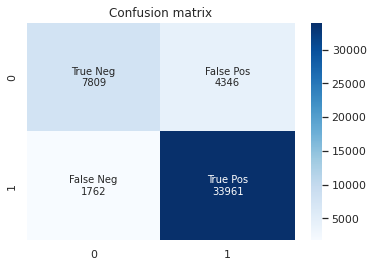

In [42]:
# ploting confusion matrix
plot_confusion_matrix(confusion_train)

### **Confusion Matrix for Test Dataset**

In [43]:
# confusion matrix
confusion_test =metrics.confusion_matrix(y_test, y_pred_class)
print(confusion_test)

[[ 2343  1663]
 [  576 11378]]


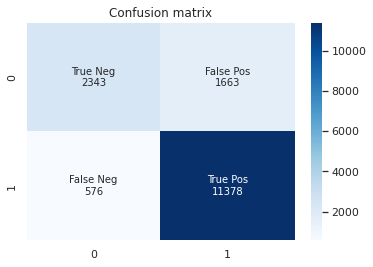

In [44]:
# ploting confusion matrix
plot_confusion_matrix(confusion_test)

### Let's calculate other Matrics - Sensitivity, Specificity, Precision,Recall and F1 score for train and test dataset


In [45]:
# for train dataset
TN_train = confusion_train[0, 0]
FP_train = confusion_train[0, 1]
FN_train = confusion_train[1, 0]
TP_train = confusion_train[1, 1]

In [46]:
# for test datset
TN_test = confusion_test[0, 0]
FP_test = confusion_test[0, 1]
FN_test = confusion_test[1, 0]
TP_test = confusion_test[1, 1]

**Sensitivity Metrics**

**Sensitivity (True Positive Rate)** is a measure of the proportion of actual positive cases that got predicted as positive.

**Specificity (True Negative Rate)** is defined as the proportion of actual negatives, which got predicted as the negative (or true negative).

**Sensitivity and Specificity** measures are used to plot the ROC curve. And, Area under ROC curve (AUC) is used to determine the model performance.

`True Positive Rate = True Positives / (True Positives + False Negatives)`

`False Positive Rate = False Positives / (False Positives + True Negatives)`

**For this particular problem, the metrics that have been chosen are sensitivity and specificity. The reason being, you do not want to make the same mistake as your competitor that had resulted in a negative sentiment of the customer (specificity), and at the same time your product should also cover the aspects that have resulted in positive sentiment for the competitor products (sensitivity)**

In [47]:
sensitivity_train = TP_train / float(FN_train + TP_train)
sensitivity_test = TP_test / float(FN_test + TP_test)
print("sensitivity on train dataset",sensitivity_train)
print("sensitivity on test dataset",sensitivity_test)

sensitivity on train dataset 0.9506760350474485
sensitivity on test dataset 0.9518152919524845


**Specificity Metrics**

In [48]:
specificity_train = TN_train / float(TN_train + FP_train)
specificity_test = TN_test / float(TN_test + FP_test)
print("specificity on train dataset",specificity_train)
print("specificity on train dataset",specificity_test)

specificity on train dataset 0.6424516659810777
specificity on train dataset 0.5848726909635547


**Precision Metrics**

In [49]:
precision_train = TP_train / float(TP_train + FP_train)
precision_test = TP_test / float(TP_test + FP_test)
print("precision on train dataset",precision_train)
print("precision on test dataset",precision_test)

precision on train dataset 0.8865481504685828
precision on test dataset 0.8724791043631623


**Recall Metrics**

In [50]:
print("RECALL SCORE on train dataset :", metrics.recall_score(y_train, y_pred_train))
print("RECALL SCORE on test dataset :", metrics.recall_score(y_test, y_pred_class))

RECALL SCORE on train dataset : 0.9506760350474485
RECALL SCORE on test dataset : 0.9518152919524845


**F1 Score**

In [51]:
print("F1 SCORE for train dataset :",metrics.f1_score(y_train, y_pred_train))
print("F1 SCORE for test dataset :",metrics.f1_score(y_test, y_pred_class))

F1 SCORE for train dataset : 0.9174929082804268
F1 SCORE for test dataset : 0.9104220844168834


In [52]:
y_pred_class

array([1, 1, 1, ..., 1, 1, 1])

In [53]:
y_pred_proba

array([[0.02332432, 0.97667568],
       [0.00200333, 0.99799667],
       [0.06007884, 0.93992116],
       ...,
       [0.02952629, 0.97047371],
       [0.32812413, 0.67187587],
       [0.44717928, 0.55282072]])

**ROC Curve**

In [66]:
# creating an ROC curve
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

In [59]:
# for train dataset
false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, y_pred_proba_tr[:,1])
roc_auc_tr = auc(false_positive_rate_tr, true_positive_rate_tr)


In [60]:
# for test dataset
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

In [61]:
# area under the curve
print (roc_auc)

0.8963961828714182


In [62]:
# matrix of thresholds, tpr, fpr
pd.DataFrame({'Threshold': thresholds, 
              'TPR': true_positive_rate, 
              'FPR':false_positive_rate
             })

,Threshold,TPR,FPR
0,2.000000e+00,0.000000,0.000000
1,1.000000e+00,0.091685,0.005492
2,1.000000e+00,0.093023,0.005492
3,1.000000e+00,0.095700,0.005741
4,1.000000e+00,0.095867,0.005741
...,...,...,...
3308,2.308885e-34,0.999749,0.999001
3309,1.866133e-34,0.999749,0.999501
3310,6.389300e-38,0.999833,0.999501
3311,5.001676e-92,0.999833,1.000000


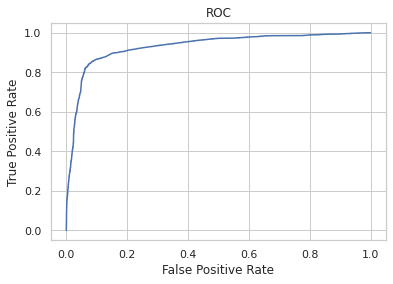

In [89]:
# plotting the ROC curve for train set
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate_tr, true_positive_rate_tr)

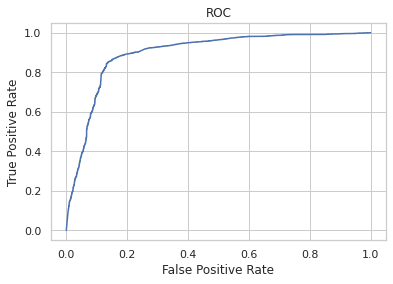

In [63]:
# plotting the ROC curve for test set
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)


## We have checked sensitivity- specificity and precision-recall matrix for the model.

### Models accuracy,sensitivity,specificity on train and test dataset are :
- Train dataset :accuracy(87%),sensitivity (95%),specificity(64%)
- Test Dataset : accuracy(86%),sensitivity (95%),specificity(59%)

### Models precision,recall,F1 score on train and test dataset are :
- Train dataset :precision(88%),recall (95%),F1 score(92%)
- Test Dataset : precision(87%),recall (95%),F1 score(91%)
- Area under curve : 90%

Since the distribution of the dataset is imbalanced with more positives, many reviews which were negative were incorrectly classified as positives by the NB model and hence the low specificity. From a business point of view, this is not a very good model as you will miss out on the negatives of your competitors. Knowing the weaknesses of your competitors help you design better features for the product and devise your marketing strategies accordingly.

In [68]:
# Printing the classification report
print("report for train set")
print(classification_report(y_train, y_pred_train))
print("report for test set")
print(classification_report(y_test, y_pred_class))

report for train set
              precision    recall  f1-score   support

           0       0.82      0.64      0.72     12155
           1       0.89      0.95      0.92     35723

    accuracy                           0.87     47878
   macro avg       0.85      0.80      0.82     47878
weighted avg       0.87      0.87      0.87     47878

report for test set
              precision    recall  f1-score   support

           0       0.80      0.58      0.68      4006
           1       0.87      0.95      0.91     11954

    accuracy                           0.86     15960
   macro avg       0.84      0.77      0.79     15960
weighted avg       0.85      0.86      0.85     15960



Macro average is just the average of performance metrics of both the classes where as the weighted average assigns weights to the metrics of the classes according to their distribution in the original dataset. Macro and weighted averages are more useful in a multi-class calssification problems because in case of a binary classification, we already know what our positive and negative classes are, to evaluate the model performance.


## Model 2: With Oversampling 
A skewed data is the one where there are more training examples for one class than another. This was evident from the specificity which was calculated in the model above. This can cause the decision boundary weights to be biased. This causes
the classifier to unwittingly prefer one class over the
other.

We have shown the reason for the bias in the previous model and propose to alleviate the problem by using a method called **Random oversampling**. Random oversampling involves randomly selecting samples from the minority class (in our case 0s), with replacement, and adding them to the training dataset such that there is an equal distribution of the classes. 



In [69]:
# splitting the data into test and train
from sklearn.model_selection  import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [70]:
pd.Series(y_train).value_counts()

1    35723
0    12155
Name: review_sentiment, dtype: int64

Why oversampling is done only on training set? <br>If both the train and test data are oversampled, we may end up having same points in both the sets. Hence the model performance obtained cannot be reliable as the test set is not independent of the train set.


In [71]:
#from imblearn import over_sampling
from imblearn import over_sampling
ros = over_sampling.RandomOverSampler(random_state=0)

In [72]:
X_train, y_train = ros.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))

In [73]:
pd.Series(y_train).value_counts()

1    35723
0    35723
Name: review_sentiment, dtype: int64

In [74]:
#Distribution of the data in terms of proportions can now be seen as 50 -50
print("Percent of 1s: ", 100*pd.Series(y_train).value_counts()[1]/pd.Series(y_train).value_counts().sum(), "%")
print("Percent of 0s: ", 100*pd.Series(y_train).value_counts()[0]/pd.Series(y_train).value_counts().sum(), "%")

Percent of 1s:  50.0 %
Percent of 0s:  50.0 %


In [75]:
# vectorizing the sentences
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [76]:
# The CountVectorizer object, vect takes in a list of string as an argument. to get a list of string from a 2D array,
# we convert the 2D array to a dataframe and then convert it to a list.

X_train = pd.DataFrame(X_train).iloc[:,0].tolist()

#Printing a few samples from the list
X_train[:6]

['buy phone mom ago work great like complaints get sale happy shes happy',
 'good',
 'happy phone expect meet delivery time responsible seller thank please',
 'purchase phone upgrade aka optimus true lte absolutely love phone fast brilliant screen gen pro specs rival newly release super phone motorola apple etc compare favourably note note compare price definitely bargain offer great battery life excellent phone call audio plus bell whistle',
 'gift granddaughter love',
 'recomend buyer quick responsable buy expect buy recomend']

In [77]:
#Fitting X_train into a vectorizer
vect.fit(X_train)

CountVectorizer()

In [78]:
# Transforming the train and test datasets
X_train_transformed = vect.transform(X_train)
X_test_transformed = vect.transform(X_test)

##**Naive Bayes model with random oversampling**

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [80]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

# fit
mnb.fit(X_train_transformed,y_train)

# Training dataset
y_pred_train = mnb.predict(X_train_transformed)
y_pred_proba_tr = mnb.predict_proba(X_train_transformed)

# Testing dataset
y_pred = mnb.predict(X_test_transformed)
y_pred_proba = mnb.predict_proba(X_test_transformed)

In [81]:
# note that alpha=1 is used by default for smoothing
mnb

MultinomialNB()

##Model evauation on Test dataset

In [82]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [83]:
# printing the overall accuracy
from sklearn import metrics
print("Accuracy for test set is: ", metrics.accuracy_score(y_test, y_pred))
print("Accuracy for train set is: ", metrics.accuracy_score(y_train, y_pred_train))

Accuracy for test set is:  0.856077694235589
Accuracy for train set is:  0.874730565741959


Confusion matrix for train and test set


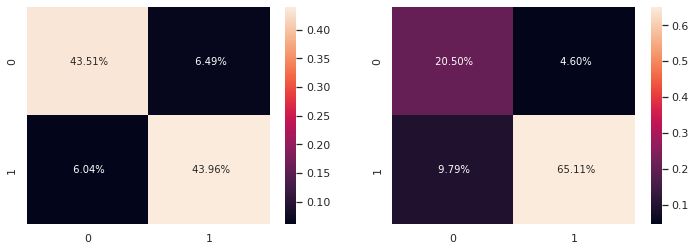

In [84]:
#Confusion matrix for the train data
import seaborn as sns
import matplotlib.pyplot as plt

print("Confusion matrix for train and test set")

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
# confusion matrix for train set
cm_train = metrics.confusion_matrix(y_train, y_pred_train)
sns.heatmap(cm_train/np.sum(cm_train), annot=True , fmt = ' .2%')
# help(metrics.confusion_matrix)

plt.subplot(1,2,2)
# confusion matrix for the test data
cm_test = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(cm_test/np.sum(cm_test), annot=True , fmt = ' .2%')

plt.show()


In [85]:
# creating an ROC curve
# from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#for test set
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
#for train set
false_positive_rate_tr, true_positive_rate_tr, thresholds_tr = roc_curve(y_train, y_pred_proba_tr[:,1])
roc_auc_tr = auc(false_positive_rate, true_positive_rate)

In [86]:
# area under the curve
print ("for train set: ",roc_auc_tr)
print ("for test set: ",roc_auc)

for train set:  0.8967152729998193
for test set:  0.8967152729998193


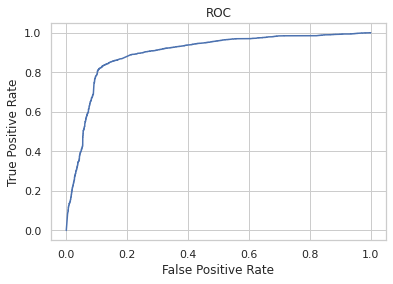

In [87]:
# plotting the ROC curve for test set
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate)

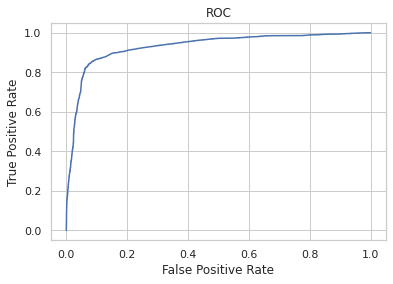

In [90]:
# plotting the ROC curve for train set
%matplotlib inline  
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC')
plt.plot(false_positive_rate_tr, true_positive_rate_tr)

In [91]:
# storing the values in variables
#for test set
TN = cm_test[0, 0]
FP = cm_test[0, 1]
FN = cm_test[1, 0]
TP = cm_test[1, 1]
#For train set
TN_tr = cm_train[0, 0]
FP_tr = cm_train[0, 1]
FN_tr = cm_train[1, 0]
TP_tr = cm_train[1, 1]

In [92]:
#specificity for test and train set.
specificity_tr = TN_tr / float(TN_tr + FP_tr)
print("specificity for train set: ",specificity_tr)
specificity = TN / float(TN + FP)
print("specificity for test set: ",specificity)

specificity for train set:  0.8702796517649694
specificity for test set:  0.8167748377433849


In [94]:
#Calculating the Sensitivity for train and test set
sensitivity_tr = TP_tr / float(FN_tr + TP_tr)
print("sensitivity for train set: ",sensitivity_tr)
sensitivity = TP / float(FN + TP)
print("sensitivity for test set: ",sensitivity)

sensitivity for train set:  0.8791814797189486
sensitivity for test set:  0.8692487870168981


### Precision

## We have checked sensitivity- specificity and precision-recall matrix for the model.
### Models accuracy,sensitivity,specificity on train and test dataset are :
Train dataset :accuracy(88%),sensitivity (88%),specificity(87%)

Test Dataset : accuracy(89%),sensitivity (87%),specificity(82%)

Area under curve : 90% for both train and test dataset.

**The test sensitivity and specificity of the model without oversampling were 0.95 and 0.59 respectively. The application of oversampling model has resulted in an equal distribution of the binary labels. This has resulted in a jump in specificity by 0.23 with a slight decrease in the sensitivity by 0.08. From a business point of view, we can say that this is a better model as compared to the one that was built without oversampling.**

In [95]:
# Printing the classification report
print("report for train set")
print(classification_report(y_train, y_pred_train))
print("report for test set")
print(classification_report(y_test, y_pred))

report for train set
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     35723
           1       0.87      0.88      0.88     35723

    accuracy                           0.87     71446
   macro avg       0.87      0.87      0.87     71446
weighted avg       0.87      0.87      0.87     71446

report for test set
              precision    recall  f1-score   support

           0       0.68      0.82      0.74      4006
           1       0.93      0.87      0.90     11954

    accuracy                           0.86     15960
   macro avg       0.81      0.84      0.82     15960
weighted avg       0.87      0.86      0.86     15960

